In [105]:
import pandas as pd
import numpy as np
import datetime
from time import ctime
import warnings
warnings.filterwarnings('ignore')

In [106]:
# Datos de entrenamiento limpios y con features agregados
train = pd.read_csv('../data/to_train_01.csv', low_memory=False, lineterminator='\n')

print(train.info())
train.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 80 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   damage_grade                            260601 non-null  int64  
 2   count_floors_pre_eq                     260601 non-null  int64  
 3   age                                     260601 non-null  int64  
 4   area_percentage                         260601 non-null  int64  
 5   height_percentage                       260601 non-null  int64  
 6   land_surface_condition                  260601 non-null  float64
 7   foundation_type                         260601 non-null  float64
 8   roof_type                               260601 non-null  float64
 9   ground_floor_type                       260601 non-null  float64
 10  other_floor_type                        2606

,building_id,damage_grade,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,802906,3,2,30,6,5,2.234176,2.329448,2.269586,2.309002,...,0.16129,1.2,30,36,25,5.5,0.5,0.166667,0.2,2


In [107]:
# Datos de prueba
test = pd.read_csv('../data/to_test_01.csv', low_memory=False, lineterminator='\n')
print(test.info())
test.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 79 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   count_floors_pre_eq                     86868 non-null  int64  
 2   age                                     86868 non-null  int64  
 3   area_percentage                         86868 non-null  int64  
 4   height_percentage                       86868 non-null  int64  
 5   land_surface_condition                  86868 non-null  float64
 6   foundation_type                         86868 non-null  float64
 7   roof_type                               86868 non-null  float64
 8   ground_floor_type                       86868 non-null  float64
 9   other_floor_type                        86868 non-null  float64
 10  position                                86868 non-null  fl

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,300051,3,20,7,6,2.234176,2.329448,2.269586,2.309002,2.315611,...,0.285714,1.166667,42,49,36,6.5,0.333333,0.142857,0.166667,1


## Entrenamiento del modelo

### Seleccion de features

In [108]:
def seleccion_de_features_to_remove(df_train):
    '''
    Funcion para seleccionar features.
    features_to_remove es la base que contiene building_id y damage_grade
    Las demas listas, las creamos y las agregamos a subset_features para luego appendearlas a features_to_remove
    '''
    features_to_remove = ['building_id', 'damage_grade']
    subset_features = []
    has_secondary = [col for col in df_train.columns if 'has_secondary' in col]
    legal_ownership = [col for col in df_train.columns if 'legal_ownership' in col]
    plan_configuration = [col for col in df_train.columns if 'plan_configuration' in col]
    probas = [col for col in df_train.columns if 'proba_danio' in col]
    relaciones_geo = [col for col in df_train.columns if 'relacion_' in col]
    cantidad_geo = [col for col in df_train.columns if 'cant_geolevel' in col]
    geo_level_embedded = [col for col in df_train.columns if 'geo_level_embedded_' in col]
    subset_features.append(has_secondary)
    subset_features.append(cantidad_geo)
    subset_features.append(legal_ownership)
    subset_features.append(relaciones_geo)
    #subset_features.append(geo_level_embedded)
    #subset_features.append(probas)
    subset_features.append(plan_configuration)
    for subset in subset_features:
        features_to_remove += subset
    return features_to_remove

In [109]:
#features_adicionales_a_remover = ['proba_danio_1_dado_geolevel3', 'proba_danio_2_dado_geolevel3', 'proba_danio_3_dado_geolevel3']
#otras_features_a_sacar = ['has_superstructure_stone_flag', 'has_superstructure_other', 'has_superstructure_bamboo', 'has_superstructure_cement_mortar_stone',\
#      'has_superstructure_adobe_mud']

In [110]:
features_to_remove = seleccion_de_features_to_remove(train)
Y = train['damage_grade']
X = train.drop(features_to_remove, axis=1)

In [111]:
from sklearn import ensemble
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208480 entries, 170377 to 121958
Data columns (total 57 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     208480 non-null  int64  
 1   age                                     208480 non-null  int64  
 2   area_percentage                         208480 non-null  int64  
 3   height_percentage                       208480 non-null  int64  
 4   land_surface_condition                  208480 non-null  float64
 5   foundation_type                         208480 non-null  float64
 6   roof_type                               208480 non-null  float64
 7   ground_floor_type                       208480 non-null  float64
 8   other_floor_type                        208480 non-null  float64
 9   position                                208480 non-null  float64
 10  has_superstructure_adobe_mud           

### Entrenamiento

> https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

> https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [113]:
from sklearn.metrics import f1_score

#DD = 0.7444
#Training Score: 0.7970
#Test Score:  0.7613

# Sin plan configuration
#Training Score: 0.7966
#Test Score:  0.7619

best_params = {
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'n_estimators': 500,
    'n_jobs': -1,
    'num_class': 3,
    'objective': 'multi:softmax',
    'verbosity': 1
}

    
print('Hora antes de empezar a tunear/entrenar: {}'.format(ctime()))
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)
print('Hora al finalizar de tunear/entrenar: {}'.format(ctime()))

# Vemos el score comprobando contra el set de test y de train
y_pred_test = model.predict(X_test)
model_f1_micro_test = f1_score(y_test, y_pred_test, average='micro')
y_pred_train = model.predict(X_train)
model_f1_micro_train = f1_score(y_train, y_pred_train, average='micro')
print("Training Score: %.4f" % model_f1_micro_train)
print("Test Score:  %.4f" % model_f1_micro_test)

Hora antes de empezar a tunear/entrenar: Tue Jul 13 22:22:11 2021
[22:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Hora al finalizar de tunear/entrenar: Tue Jul 13 22:29:16 2021
Training Score: 0.7966
Test Score:  0.7619


### Feature importance

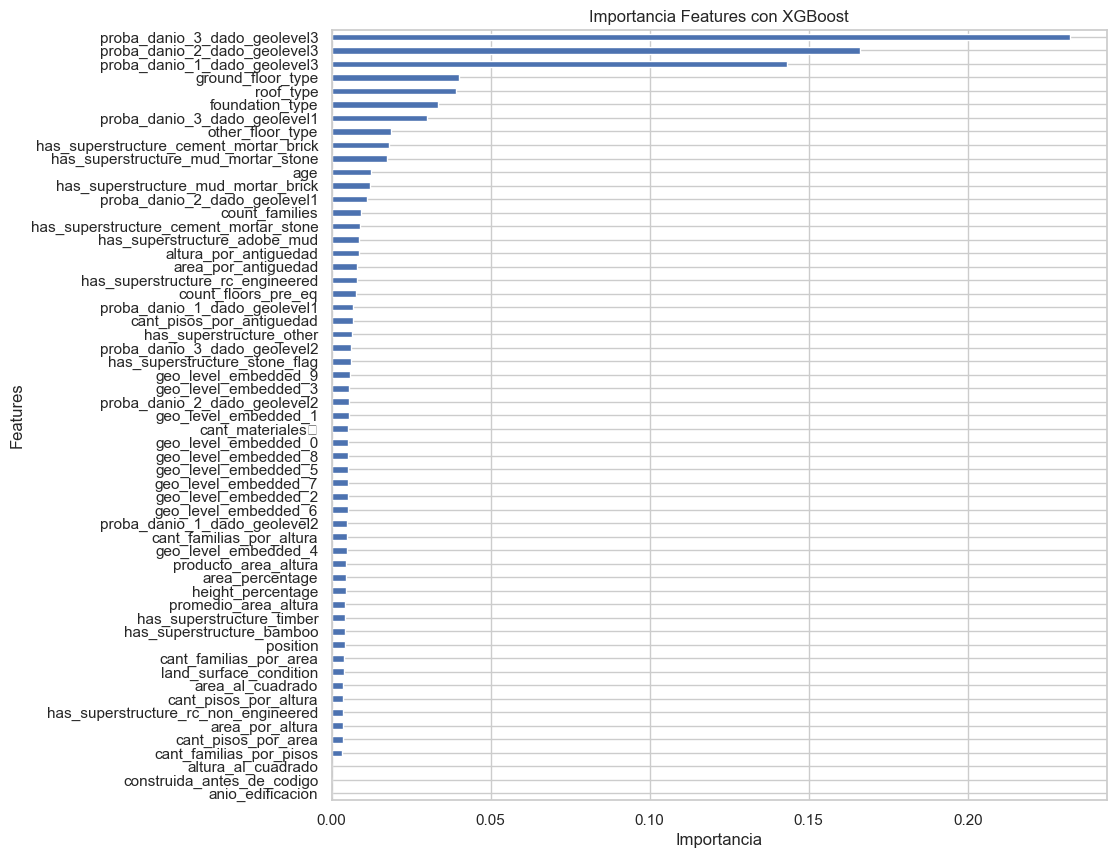

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')
sns.set(style="whitegrid") # seteando tipo de grid en seaborn


feature_cols = X.columns.tolist()
features = pd.Series(data=model.feature_importances_, index=feature_cols, name='Feature importance')
features.sort_values(ascending=True, inplace=True)
plt.figure(figsize=(10, 10))
features.plot(kind='barh')
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.title('Importancia Features con XGBoost')
plt.show()

<Figure size 1200x1200 with 0 Axes>

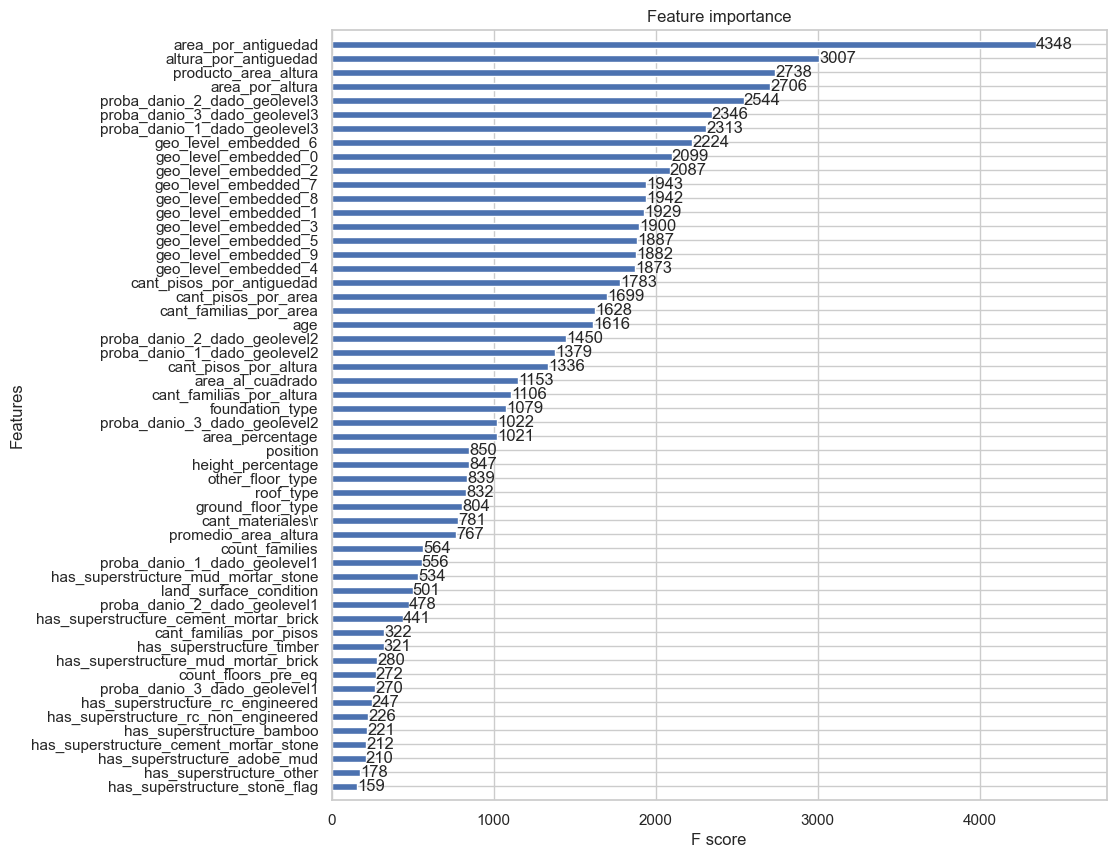

In [115]:
plt.figure(figsize=(12, 12))
plt.rcParams["figure.figsize"] = (10,10)
xgb.plot_importance(model, height=0.5, grid=True)
plt.show()

In [116]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

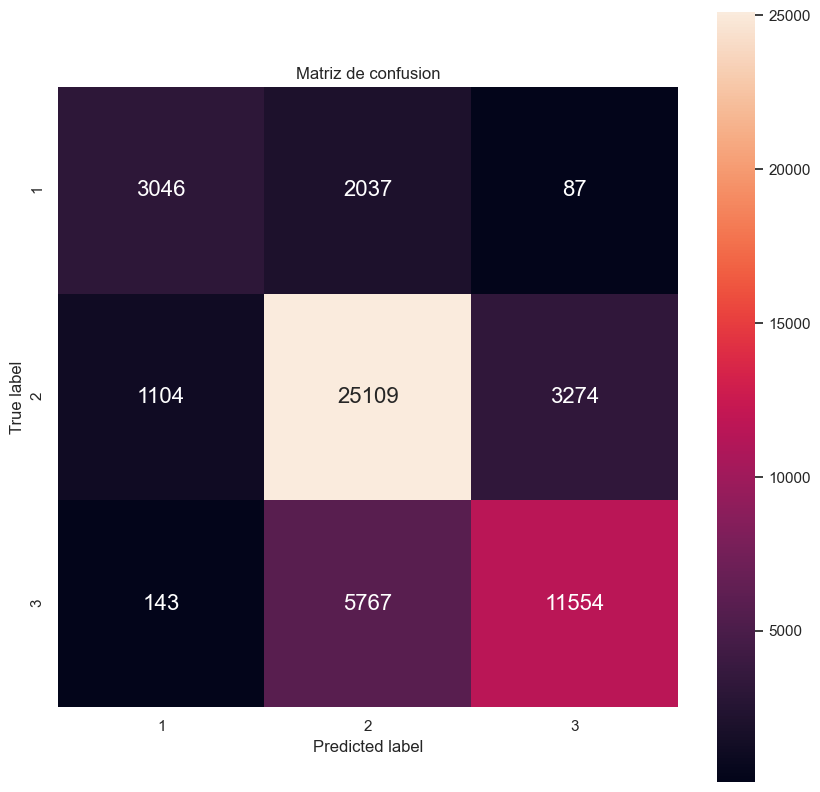

In [117]:
plot_confusion_matrix(y_test, y_pred_test)

### Prediccion del modelo

In [100]:
# Saco damage_grade de las features a remover ya que dicha feature NO esta en el set de test
features_to_remove.remove('damage_grade')
to_test = test.drop(features_to_remove, axis=1)

In [101]:
y_pred = model.predict(to_test)
y_pred

array([3, 2, 3, ..., 2, 2, 2], dtype=int64)

### Formateo de la prediccion para un submit

In [102]:
test_id = test['building_id']
test_id

0         300051
1          99355
2         890251
3         745817
4         421793
          ...   
86863     310028
86864     663567
86865    1049160
86866     442785
86867     501372
Name: building_id, Length: 86868, dtype: int64

In [103]:
submit = pd.concat([test_id, pd.Series(y_pred, name='damage_grade')], axis=1)
submit.set_index('building_id', inplace=True)
submit.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [104]:
submit.to_csv('../submits-csv/submit-XGBoost-{}.csv'.format(model_f1_micro_test))